In [39]:
import tensorflow as tf 
import keras
from keras.callbacks import *
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot 
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator

In [40]:
traindata = pd.read_csv('/Users/ajones/Documents/pytorch-test/sl/sign_mnist_train/sign_mnist_train.csv')

In [41]:
traindata.head(4)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163


In [42]:
traindata.shape

(27455, 785)

In [43]:
trainlabel=traindata['label'].values
traindata.drop('label',inplace=True,axis=1)
trainimages = traindata.values
##inserted images will be (28,28,1)
trainimages = trainimages.reshape(-1,28,28,1)

In [44]:
testdata = pd.read_csv('/Users/ajones/Documents/pytorch-test/sl/sign_mnist_test/sign_mnist_test.csv')

In [45]:
testlabel=testdata['label'].values
testdata.drop('label',inplace=True,axis=1)
testimages = testdata.values
testimages=testimages.reshape(-1,28,28,1)

In [46]:
traingen=ImageDataGenerator(rotation_range=20,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            horizontal_flip=True,
                            rescale=1/255.0,#normalising the data
                            validation_split=0.2 #train_val split
                            )

In [47]:
traindata_generator = traingen.flow(trainimages,trainlabel,subset='training')
validationdata_generator = traingen.flow(trainimages,trainlabel,subset='validation')

In [48]:
testgen=ImageDataGenerator(rescale=1/255.0)

In [49]:
testdata_generator = testgen.flow(testimages,testlabel)

In [50]:
model=Sequential([])

#convulation layer 1
model.add(Conv2D(64,(3,3),activation="relu",input_shape=(28,28,1)))
model.add(MaxPooling2D(2,2))

#convulation layer 2
model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(26,activation="softmax"))

In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 3200)              0         
                                                                 
 dense_4 (Dense)             (None, 256)              

In [52]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [53]:
history=model.fit(traindata_generator,epochs=50,validation_data=validationdata_generator)

Epoch 1/50
687/687 [==============================] - 10s 14ms/step - loss: 2.1333 - accuracy: 0.3444 - val_loss: 1.3325 - val_accuracy: 0.5722
Epoch 2/50
687/687 [==============================] - 10s 14ms/step - loss: 0.9909 - accuracy: 0.6733 - val_loss: 0.7867 - val_accuracy: 0.7461
Epoch 3/50
687/687 [==============================] - 10s 14ms/step - loss: 0.6735 - accuracy: 0.7772 - val_loss: 0.6288 - val_accuracy: 0.7897
Epoch 4/50
687/687 [==============================] - 11s 15ms/step - loss: 0.5070 - accuracy: 0.8340 - val_loss: 0.5061 - val_accuracy: 0.8283
Epoch 5/50
687/687 [==============================] - 10s 15ms/step - loss: 0.3923 - accuracy: 0.8698 - val_loss: 0.3603 - val_accuracy: 0.8831
Epoch 6/50
687/687 [==============================] - 10s 15ms/step - loss: 0.3343 - accuracy: 0.8898 - val_loss: 0.3428 - val_accuracy: 0.8803
Epoch 7/50
687/687 [==============================] - 10s 15ms/step - loss: 0.2851 - accuracy: 0.9094 - val_loss: 0.2663 - val_accuracy:

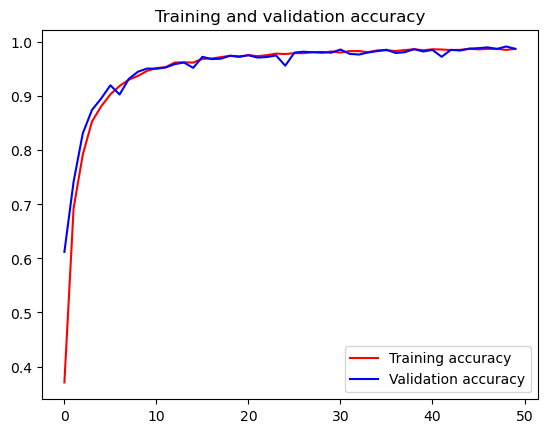

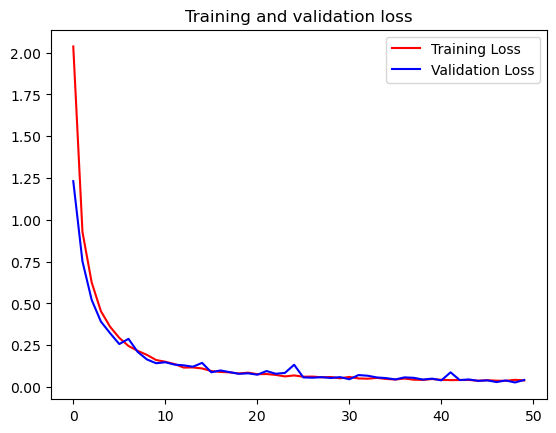

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

pyplot.plot(epochs, acc, 'r', label='Training accuracy')
pyplot.plot(epochs, val_acc, 'b', label='Validation accuracy')
pyplot.title('Training and validation accuracy')
pyplot.legend()
pyplot.figure()

pyplot.plot(epochs, loss, 'r', label='Training Loss')
pyplot.plot(epochs, val_loss, 'b', label='Validation Loss')
pyplot.title('Training and validation loss')
pyplot.legend()

pyplot.show()

In [38]:
loss,accuracy = model.evaluate(testdata_generator)
print("test accuracy: "+ str(accuracy*100))

225/225 [==============================] - 1s 6ms/step - loss: 0.0079 - accuracy: 0.9969
test accuracy: 99.69325065612793
